In [1]:
# Import packages
import os
from sys import platform
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import NaN
import statsmodels.formula.api as smf
import statsmodels.api as sm
import textwrap


# Import the datasets
# We will not be using all the datasets but we will load them on anyways
if platform == "linux" or platform == "darwin":
    path = os.getcwd()
    file_names = glob.glob("f1_dataset_kaggle/*.csv")
    file_names = [i.split("/", 1)[1] for i in file_names]
    file_names = [i.split(".", 1)[0] for i in file_names]
elif platform == "win32":
    path = os.getcwd()
    path = path.replace("\\", "/")
    file_names = glob.glob("f1_dataset_kaggle/*.csv")
    file_names = [i.replace("\\", "/") for i in file_names]
    file_names = [i.split("/", 1)[1] for i in file_names]
    file_names = [i.split(".", 1)[0] for i in file_names]


for file in file_names:
    globals()[str(file)] = pd.read_csv(path + "/f1_dataset_kaggle/" + file + ".csv")


def view_dataframes():
    """See all available dataframes in its original form."""
    print(
        f"Available dataframes: \n"
        f"----------------------------------------------------------------------\n"
    )
    for file in file_names:
        print(
            f"----------------------------------------------------------------------\n"
            f"{file} \n"
            f"----------------------------------------------------------------------\n"
            f"{globals()[file].head()} \n"
            f"----------------------------------------------------------------------\n"
        )


In [2]:
# Create a dataframe for pitstops
# Get pitstop data and merge with lap times
# We found that the pit stop data were only began collected at a certain grand prix
# The first row with a pit stop is indexed at row 268,822
# But that is at lap 16, we need to go back 16 rows above to get the full race
df_pitstops = (
    pd.merge(
        lap_times.drop(columns=["time"]),
        pit_stops[["raceId", "driverId", "lap", "stop"]],
        how="left",
        on=["raceId", "driverId", "lap"],
    )
    .sort_values(by=["raceId", "driverId", "lap"])
    .reset_index(drop=True)
)[268807:].reset_index(drop=True)

# Get the average pit stops for every raceId (every Grand Prix has a unique raceId)
# First we need to get max pitstop per raceId and per driverId
# Every driver pits different amount of times, we just want to see the average
max_pit = (
    df_pitstops.groupby(["raceId", "driverId"])["stop"]
    .max()
    .to_frame(name="max_pit")
    .reset_index()
)

# Then we take the average of the max number of pit stop per driver for every raceId
avg_pit = (
    max_pit.groupby("raceId")["max_pit"].mean().to_frame(name="avg_pit").reset_index()
)

# Wanna get the total lap per raceId too
max_lap = (
    df_pitstops.groupby(["raceId", "driverId"])["lap"]
    .max()
    .to_frame(name="max_lap")
    .reset_index()
)

# We now have the maximum number of pitstops taken by every driver on every race
# Example: plot the number of pit stops taken by every driver in race 841
# Note: available raceIds are in max_pit.raceId.unique()
def fig_pit_example(raceId):
    """See chart of drivers' pit stop frequency for any raceId"""
    max_pit[max_pit["raceId"] == raceId].sort_values(by="max_pit").plot(
        figsize=(9, 6), x="driverId", y="max_pit", kind="bar"
    )
    plt.axhline(
        y=avg_pit[avg_pit["raceId"] == raceId].iloc[0, 1],
        color="r",
        linestyle="-.",
        alpha=0.5,
        label="avg_pit",
    )
    plt.legend()
    plt.show()


In [3]:
# Get an indication if it is the final lap
# We use an arbitrarily high number (999) in column "stop" to indicate end of race
# We use df_pitstops['lap'] == df_pitstops['max_lap'] to determine last lap
# early with the rationale is that if the lap number is equal to a driver's max lap for
# that particular raceId, then that lap is the last lap
df_pitstops = pd.merge(df_pitstops, max_lap, how="left", on=["raceId", "driverId"])
df_pitstops["stop"] = np.where(
    df_pitstops["lap"].values == df_pitstops["max_lap"].values,
    999,
    df_pitstops["stop"].values,
)
df_pitstops = df_pitstops.drop(columns="max_lap")  # drop max_lap - no longer needed

# Use shift to have a row with position before pit stop
df_pitstops["pos_shift"] = df_pitstops["position"].shift(1)

# If last lap, take position at last lap
# If not last lap, take position in previous lap
df_pitstops["before_pit"] = np.where(
    df_pitstops["stop"].values == 999.0, df_pitstops["position"].values, NaN
)
df_pitstops["before_pit"] = np.where(
    df_pitstops["stop"] > 0,
    df_pitstops["pos_shift"].values,
    df_pitstops["before_pit"].values,
)
df_pitstops = df_pitstops.drop(columns="pos_shift")  # drop unnecessary column

# The issue now is that we need to remove drivers that didn't finish the race, because
# if we don't that those driver will drag the average down and make it in accurate
# We will do that by saying that if driver's "max_lap" is less than the last 5 laps,
# then that driver is considered as not having finished the race
# We would have to groupby raceId and to get number of laps for every raceId
# Filter df_pitstops for drivers that have max_lap < max_lap_adj
max_lap_adj = (
    df_pitstops.groupby("raceId")["lap"]
    .max()
    .to_frame(name="max_lap_adj")
    .reset_index()
)
max_lap_adj["max_lap_adj"] = max_lap_adj["max_lap_adj"] - 5
# df_pitstops = pd.merge(df_pitstops, max_lap_adj, how="left", on=["raceId", "driverId"])
# We now need to find the max lap for every driverId for every raceId
remove_dnf = pd.merge(max_lap, max_lap_adj, how="left", on="raceId")
remove_dnf["bool"] = np.where(
    remove_dnf["max_lap"] < remove_dnf["max_lap_adj"], False, True
)
df_pitstops = pd.merge(df_pitstops, remove_dnf, how="left", on=["raceId", "driverId"])
df_pitstops = df_pitstops[df_pitstops["bool"] == True]
df_pitstops = df_pitstops.drop(columns="bool")

# For control, we need to check for "normal" pit stop i.e., for all pit stops
# In order to do this, we need to confirm that pit stops are just routine
# i.e., they do not contribute to a driver going up or down in position

# First get all the pit stops and clean a little bit
pit_all = df_pitstops.drop(columns=["lap", "position", "milliseconds"])
pit_all = pit_all[pit_all["stop"] > 0]

# Now we need to see the positional changes (delta) between the pitstops
pit_all["temp"] = pit_all["before_pit"].shift(-1)
pit_all["pos_chg"] = pit_all["temp"] - pit_all["before_pit"]

# Drop the columns 'before_pit' and 'temp' as we don't need them anymore
# Also drop the row for last lap because we only needed 'em to calculate the delta
pit_all = pit_all.drop(columns=["before_pit", "temp"])
pit_all = pit_all.drop(pit_all[pit_all["stop"] == 999.0].index)

# Now let's look at the mean pos_chg between "routine" pit stops
pit_all_mean = pit_all["pos_chg"].mean()

# Now let's look at pit stops that are less than average
# First get all the pit stops that are less than the average
pit_control = pd.merge(
    df_pitstops.drop(columns=["lap", "position", "milliseconds"]),
    avg_pit,
    how="left",
    on="raceId",
)
pit_control = pit_control[pit_control["stop"] > 0]
pit_control = pit_control[
    (pit_control["stop"] < pit_control["avg_pit"]) | (pit_control["stop"] == 999.0)
]
pit_control = pit_control.drop(columns="avg_pit")

# Now we need to see the positional changes (delta) between the pitstops
pit_control["temp"] = pit_control["before_pit"].shift(-1)
pit_control["pos_chg"] = pit_control["temp"] - pit_control["before_pit"]

# Drop the columns 'before_pit' and 'temp' as we don't need them anymore
# Also drop the row for last lap because we only needed 'em to calculate the delta
pit_control = pit_control.drop(columns=["before_pit", "temp"])
pit_control = pit_control.drop(pit_control[pit_control["stop"] == 999.0].index)

# Now let's look at the mean pos_chg between "normal" pit stops
pit_control_mean = pit_control["pos_chg"].mean()

# Now we'll look at the more-than average pitstops
pit_more = pd.merge(
    df_pitstops.drop(columns=["lap", "position", "milliseconds"]),
    avg_pit,
    how="left",
    on="raceId",
)
pit_more = pit_more[pit_more["stop"] > 0]
pit_more = pit_more[
    (pit_more["stop"] > pit_more["avg_pit"]) | (pit_more["stop"] == 999.0)
]
pit_more = pit_more.drop(columns="avg_pit")

# Now we need to see the positional changes between the pitstops
pit_more["temp"] = pit_more["before_pit"].shift(-1)
pit_more["pos_chg"] = pit_more["temp"] - pit_more["before_pit"]

# Drop the columns 'before_pit' and 'temp' as we don't need them anymore
# Also drop the row for last lap because we only needed 'em to calculate the delta
pit_more = pit_more.drop(columns=["before_pit", "temp"])
pit_more = pit_more.drop(pit_more[pit_more["stop"] == 999.0].index)

# Now let's look at the mean pos_chg between "routine" pit stops
pit_more_mean = pit_more["pos_chg"].mean()


def view_delta():
    """View the positional delta of all, control, and more pit stops"""
    print(
        f"Positional Delta for Pit Stop Types \n"
        f"----------------------------------- \n"
        f"All Pit Stops: {round(pit_all_mean, 2)} \n"
        f"Control Pit Stops: {round(pit_control_mean, 2)} \n"
        f"Extra Pit Stops: {round(pit_more_mean, 2)} \n"
    )


# Want to see if drivers take extra pitstops are actually at the back fo the grid We
# have the datarame pit_all, pit_control, and pit_more, with all drivers that took extra
# pitstops, let's look at the average position for all of them
# Need to get position back from results though
df_list = ["pit_all", "pit_control", "pit_more"]
pit_pos_avg = []

for i in df_list:
    globals()[str(i)] = pd.merge(
        globals()[str(i)],
        results[["raceId", "driverId", "rank"]],
        how="left",
        on=["raceId", "driverId"],
    )
    globals()[str(i)]["rank"] = pd.to_numeric(globals()[str(i)]["rank"])
    temp = globals()[str(i)]["rank"].mean()
    pit_pos_avg.append(temp)


def view_rank_pos():
    """See average position drivers finish for all pit stops, normal pitstops, and extra
    pit stops"""
    print(
        f"Average Driver Position at End of Race \n"
        f"-------------------------------------- \n"
        f"All Pit Stops: {round(pit_pos_avg[0], 2)} \n"
        f"Control Pit Stops: {round(pit_pos_avg[1], 2)} \n"
        f"Extra Pit Stops: {round(pit_pos_avg[2], 2)} \n"
    )


In [4]:
# Performing regressions
# Perform a regression on all pit stops
reg_pit_all = smf.ols("pos_chg~stop", data=pit_all).fit()
with open("tables/all_pits.tex", "w") as fh:
    for table in reg_pit_all.summary().tables:
        fh.write(table.as_latex_tabular())

# Perform a regression on all "normal" pit stops
reg_pit_control = smf.ols("pos_chg~stop", data=pit_control).fit()
with open("tables/control_pit.tex", "w") as fh:
    for table in reg_pit_control.summary().tables:
        fh.write(table.as_latex_tabular())

# Perform a regressions for more-than-average pit stop
reg_pit_more = smf.ols("pos_chg~stop", data=pit_more).fit()
with open("tables/more_pit.tex", "w") as fh:
    for table in reg_pit_more.summary().tables:
        fh.write(table.as_latex_tabular())


def view_reg():
    print(
        f"--------------------------------------------------------------------------\n"
        f"Regression for All Pit Stops \n"
        f"--------------------------------------------------------------------------\n"
        f"{reg_pit_all.summary()}"
        f"--------------------------------------------------------------------------\n"
        f"--------------------------------------------------------------------------\n"
        f"Regression for Normal Pit Stops \n"
        f"--------------------------------------------------------------------------\n"
        f"{reg_pit_control.summary()}"
        f"--------------------------------------------------------------------------\n"
        f"--------------------------------------------------------------------------\n"
        f"Regression for Extra Pit Stops \n"
        f"--------------------------------------------------------------------------\n"
        f"{reg_pit_more.summary()}"
        f"--------------------------------------------------------------------------\n"
    )


In [5]:
# Now that we have looked at the positional delta, we want to now look if drivers that
# take extra pit stops, on average, managed to at least reduce their gap to the driver
# right in front of them
# To do this, we will first look at the change in laptime-delta-to-leader between
# pitstops, and then the change in laptime-delta-to-defender
# Note: we call it defender caues the driver right ahead is "defending" his position
# Essentially, we want to see if the driver that takes that extra pitstop, even if they
# didn't get a position, did they at least get to catch up a little bit?
# If not, what is really the point of pitting more?

# To look at a driver's laptime for just one race
def fig_laptime(raceId, driverId):
    """A look at a driver's laptime for any particular race"""
    pit_analysis = df_pitstops[
        (df_pitstops["raceId"] == raceId) & (df_pitstops["driverId"] == driverId)
    ]
    pit_analysis.plot(x="lap", y="milliseconds", figsize=(9, 6))
    plt.show()


# Create a dataframe from lap_times, sorted
df_laptimes = lap_times.sort_values(by=["raceId", "driverId", "lap"])

# Get the cumulative laptimes of every driver for every lap and race
df_laptimes["milliseconds"] = df_laptimes.groupby(["raceId", "driverId"])[
    "milliseconds"
].cumsum()

# Find the shortest cumulative laptime i.e. the race leader
shortest_cum = df_laptimes.groupby(["raceId", "lap"])  # Groupby raceId and lap
shortest_cum = (
    shortest_cum["milliseconds"].min().to_frame(name="min_laptime").reset_index()
)

# Merging it with the main dataframe
df_laptimes = pd.merge(df_laptimes, shortest_cum, on=["raceId", "lap"], how="left")

# Calculate the different (the delta) between any driver on any lap and race with the
# race leader
df_laptimes["leader_distance"] = (
    df_laptimes["min_laptime"] - df_laptimes["milliseconds"]
)
df_laptimes = df_laptimes.drop("min_laptime", axis=1)

In [6]:
# Analyzing undercuts

pd.options.mode.chained_assignment = None  # default='warn'

listraces = df_pitstops.drop(
    columns=["driverId", "lap", "position", "milliseconds", "stop"]
)
listraces = listraces.drop_duplicates()
listraces = listraces.reset_index(drop=True)

race_list = []
second_win = []
second_mil = []
adj_second_mil = []

for looprace in listraces["raceId"].values:

    df_pitstops["looprace"] = looprace

    df_temp = pd.merge(df_pitstops, max_lap, how="left", on=["raceId", "driverId"])

    # Finding the 1st & 2nd place drivers of race 841 (getting their IDs)
    # Will need to figure out a way to loop through this for each race at the end
    race1 = df_temp[df_temp["raceId"] == df_temp["looprace"]]

    maxlap = race1.groupby("raceId")["lap"].max().values
    race1["maxlap"] = maxlap[0]

    race1 = race1[race1["lap"] == race1["maxlap"]]
    race1 = race1.sort_values(by=["position"])
    race1 = race1.reset_index(drop="True")

    ids = [race1.iat[0, 1], race1.iat[1, 1]]
    first_id = ids[0]
    second_id = ids[1]

    df_temp2 = pd.merge(race1, max_pit, how="left", on=["raceId", "driverId"])

    # Getting the max number of pitstops for first and second place
    mstops = [df_temp2.iat[0, 7], df_temp2.iat[1, 7]]

    testrace = df_pitstops[df_pitstops["raceId"] == looprace]
    testrace = pd.merge(testrace, max_pit, how="left", on=["raceId", "driverId"])

    firstsecond = testrace[testrace["driverId"].isin(ids)]

    firstsecondpit = firstsecond[firstsecond["stop"] == firstsecond["max_pit"]]

    mstop_laps = [firstsecondpit.iat[0, 2], firstsecondpit.iat[1, 2]]

    finaldf = firstsecond[firstsecond["driverId"] == ids[1]]

    test_df_1 = finaldf
    test_1 = test_df_1[test_df_1["lap"] == mstop_laps[1] - 1]
    test_df_1 = test_df_1.append([test_1] * 3, ignore_index=True)
    test_df_1 = test_df_1.sort_values(by="lap")

    test_df_1.drop(test_df_1.tail(3).index, inplace=True)
    test_df_1["milliseconds"] = test_df_1.groupby(["raceId", "driverId"])[
        "milliseconds"
    ].cumsum()
    second_time = test_df_1["milliseconds"][
        test_df_1["lap"] == test_df_1["lap"].max()
    ].values

    test_df_3 = finaldf
    test_df_3["milliseconds"] = test_df_3.groupby(["raceId", "driverId"])[
        "milliseconds"
    ].cumsum()
    orig_second_time = test_df_3["milliseconds"][
        test_df_3["lap"] == test_df_3["lap"].max()
    ].values

    firsttime = firstsecond[firstsecond["driverId"] == ids[0]]
    firsttime["milliseconds"] = firsttime.groupby(["raceId", "driverId"])[
        "milliseconds"
    ].cumsum()

    first_time = firsttime["milliseconds"][
        firsttime["lap"] == firsttime["lap"].max()
    ].values

    if first_time[0] > second_time[0]:
        win = 1
    elif first_time[0] == second_time[0]:
        win = 2
    else:
        win = 0

    race_list.append(looprace)
    second_win.append(win)
    second_mil.append(orig_second_time[0])
    adj_second_mil.append(second_time[0])

delayedpit = pd.DataFrame(
    list(zip(race_list, second_win, second_mil, adj_second_mil)),
    columns=["race", "change-outcome", "Original Time", "Adjusted Time"],
)

delayedpit["improvement"] = delayedpit["Original Time"] - delayedpit["Adjusted Time"]

In [7]:
# Creating table for positions and points

pos_points = {
    "Position": ["1st", "2nd", "3rd", "4th", "5th", "6th", "7th", "8th", "9th", "10th"],
    "Points": [25, 18, 15, 12, 10, 8, 6, 4, 2, 1],
}
pos_points = pd.DataFrame(pos_points, columns=["Position", "Points"])

# with open(os.path.join(os.getcwd(), "tables/pos_points.tex"), "w") as tf:
#     tf.write(
#         pos_points.reset_index(drop=True).to_latex(
#             index=False,
#             caption=(
#                 "Shows points awarded to drivers for every Grand Prix based on their "
#                 "position at the end of the race. Since there are 20 drivers on the "
#                 "grid, half of the drivers on the grid will get no points and drivers "
#                 "that not in the points will do whatever they can to get in the "
#                 "points, including taking extra pit stops to get fresher tires to "
#                 "catch up with the drivers right ahead of them."
#             ),
#             label="tab:pos-points",
#             escape=False,
#             column_format="ccc",
#             position="h",
#             bold_rows=True,
#         )
#     )

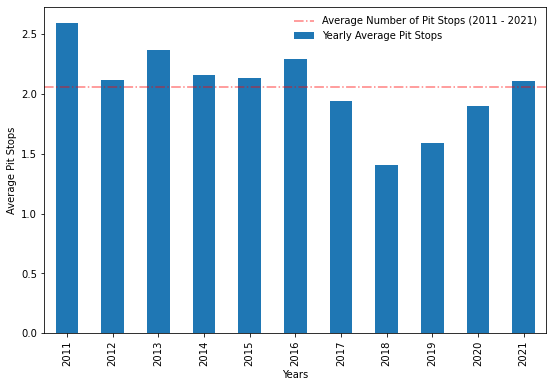

In [8]:
# Get the average number of pitstops between 2010-2020, maybe split it up by year too
# We already have the max number of pit stops that drivers take for every raceId
# We're missing the year though, need to merge that back into max_pit
# The data for year is in race, I think

avg_all = pd.merge(max_pit, races[["raceId", "year"]], how="left", on="raceId")

# Now we can see average between 2011 to 2021
avg_pit_2011_2021 = avg_all["max_pit"].mean()

# Let's look at it by year
avg_pit_yearly = (
    avg_all.groupby(["year"])["max_pit"]
    .mean()
    .to_frame(name="avg_pit_years")
    .reset_index()
).plot(
    x="year",
    y="avg_pit_years",
    ylabel="Average Pit Stops",
    xlabel="Years",
    kind="bar",
    figsize=(9, 6),
)
plt.axhline(
    y=avg_pit_2011_2021,
    color="r",
    linestyle="-.",
    alpha=0.5,
)
plt.legend(
    ["Average Number of Pit Stops (2011 - 2021)", "Yearly Average Pit Stops"],
    frameon=False,
)
plt.savefig("figures/avg_all_yearly.png")

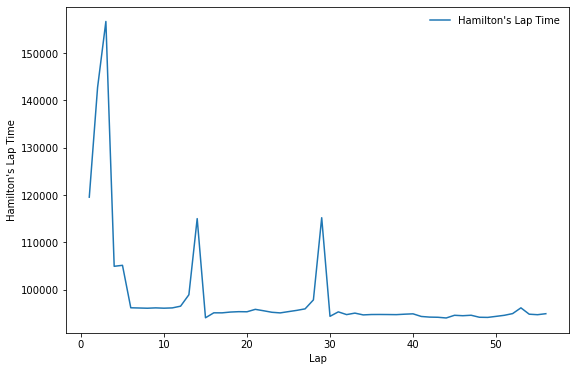

In [9]:
# Get Lewis' laptime for Bahrain this year
pit_analysis = df_pitstops[
    (df_pitstops["raceId"] == 1052) & (df_pitstops["driverId"] == 1)
]
pit_analysis.plot(
    x="lap",
    y="milliseconds",
    xlabel="Lap",
    ylabel="Hamilton's Lap Time",
    figsize=(9, 6),
)
plt.legend(
    ["Hamilton's Lap Time"],
    frameon=False,
)
plt.savefig("figures/ham_lap.png")
